### To explore the response of WUE to Ca & VPD by fitting curves

In [17]:
import numpy as np
import pandas as pd
import os
from scipy import stats
import pymannkendall as mk
from utils import mkt
import datetime as dt

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
os.chdir('/Users/weiweizhan/Desktop/Weiwei_Zhan/Projects/WUE/')

### Import data

CO2 concentration

In [3]:
# observation data (Mauna Loa)
data_obs = pd.read_csv('./Data/CO2_concentration/co2_annmean_mlo.txt',skiprows=56, sep="\s+")

# ice core data
rows_to_keep = np.arange(275,425)
data_ice = pd.read_csv('./Data/CO2_concentration/law_co2.txt',skiprows=lambda x: x not in rows_to_keep, sep="\s+",header=None)
data_ice.columns = ['year','mean']

# reset the index 
data_ice = data_ice.set_index('year')
data_obs = data_obs.set_index('year')

# select time range
data_ice = data_ice[(data_ice.index>=1900)&(data_ice.index<1959)]
data_obs = data_obs[['mean']]

data_co2 = pd.concat([data_ice, data_obs]) 
data_co2 = data_co2.rename(columns={'mean':'Ca'})


CRU data (Temperature, VPD, RH)

In [4]:
Tmp_all = pd.read_csv('./Data/CRU/Temp_all_sites.csv',index_col=0)
VPD_all = pd.read_csv('./Data/CRU/VPD_all_sites.csv',index_col=0)
RH_all  = pd.read_csv('./Data/CRU/RH_all_sites.csv',index_col=0)

In [5]:
def relative_change(var_all):
    '''
    To calculate the differences w.r.t to the first 10-year average
    '''
    ref_time = var_all.index<=1910
    for site in var_all.columns:
        var_all[[site+'_RlAnomaly']] = (var_all[[site]] - var_all[[site]][ref_time].mean())/var_all[[site]][ref_time].mean()
        
    var_all = var_all[var_all.index<=2010]
    return var_all


In [6]:
Tmp_all = relative_change(Tmp_all)
VPD_all = relative_change(VPD_all)
RH_all  = relative_change(RH_all)

In [19]:
# Tmp_all.to_csv('./Data/CRU/Temp_all_sites.csv')
# VPD_all.to_csv('./Data/CRU/VPD_all_sites.csv')
# RH_all.to_csv('./Data/CRU/RH_all_sites.csv')

In [7]:
data_co2 = data_co2[(data_co2.index.isin(RH_all.index))&(data_co2.index<=2010)]
# calculate the differences w.r.t to the first 10-year average

ref_time = data_co2.index<=1910
data_co2['Ca_RlAnomaly'] = (data_co2['Ca'] - data_co2['Ca'][ref_time].mean())/data_co2['Ca'][ref_time].mean()

Tree ring data

In [8]:
folder = './Data/Tree_Ring/'

Conifer   = ['COL','CAZ','SER','PED','LIL','VIG','POE',
             'NIE2','WIN','SUW','PAN','GUT','ILO','INA']
Broadleaf = ['CAV','LAI','REN','FON','NIE1','DRA','WOB','LCH','BRO']
All_sites = Conifer + Broadleaf

In [9]:
Ci_all,iWUE_all, WUE_all, uWUE_all = data_co2.copy(),data_co2.copy(),data_co2.copy(),data_co2.copy()


for site in (Conifer + Broadleaf):
    data = pd.read_csv(folder+site+'.csv',header=None)
    
    data.columns = ['year',site]
    
    # round the year column
    data['year'] = data.year.round().astype('int64')
    data = data.set_index('year')
    data = data[data.index>1900]
    
    # for rows with multiple same indexes (year indice), we only keep the first value
    data = data[~data.index.duplicated(keep='first')]
    
    # 2-order polynomial interpolation
    data = data.interpolate(method='polynomial', order=2)
    
    # time window to compute the initial mean state
    ref_time = Ci_all.index<=1910
    
    # all sites Ci & relative change (difference w.r.t the mean of first 10 years )
    Ci_all = pd.merge(Ci_all,data,how='outer',on='year')
    
    Ci_all[[site+'_RlAnomaly']] = (Ci_all[[site]] - Ci_all[[site]][ref_time].mean())/Ci_all[[site]][ref_time].mean() 
    
    # all sites iWUE & relative change
    iWUE_all[[site]] = ((data_co2['Ca']-Ci_all[site])/1.6).values[:,None]
    iWUE_all[[site+'_RlAnomaly']] = (iWUE_all[[site]] - iWUE_all[[site]][ref_time].mean())/iWUE_all[[site]][ref_time].mean() 
    
    # all sites WUE & relative change
    WUE_all[[site]] = ((data_co2['Ca']-Ci_all[site])/(1.6*VPD_all[site])).values[:,None]
    WUE_all[[site+'_RlAnomaly']] = (WUE_all[[site]] - WUE_all[[site]][ref_time].mean())/WUE_all[[site]][ref_time].mean() 
    
    # all sites uWUE & relative change
    uWUE_all[[site]] = ((data_co2['Ca']-Ci_all[site])/(1.6*(VPD_all[site]**0.5))).values[:,None]
    uWUE_all[[site+'_RlAnomaly']] = (uWUE_all[[site]] - uWUE_all[[site]][ref_time].mean())/uWUE_all[[site]][ref_time].mean() 
    
#     break

In [10]:
# iWUE_all.to_csv('./Data/Tree_Ring/iWUE_all_sites.csv')
# WUE_all.to_csv('./Data/Tree_Ring/WUE_all_sites.csv')
# uWUE_all.to_csv('./Data/Tree_Ring/uWUE_all_sites.csv')
# Ci_all.to_csv('./Data/Tree_Ring/Ci_all_sites.csv')

### Curve fitting

In [11]:
y_all = []
Ca    = []
VPD   = []

for site in All_sites:

    WUE_site = WUE_all[[site+'_RlAnomaly']].values
    Ca_site  = WUE_all[['Ca'+'_RlAnomaly']].values
    VPD_site = VPD_all[[site+'_RlAnomaly']].values

    y = np.log(1+WUE_site)

    # remove nan values
    Ca_site  = Ca_site[~np.isnan(y)]
    VPD_site = VPD_site[~np.isnan(y)]
    y        = y[~np.isnan(y)]
    
    y_all += y.tolist()
    Ca    += Ca_site.tolist()
    VPD   += VPD_site.tolist()

y_all = np.array(y_all)
Ca    = np.array(Ca)
VPD   = np.array(VPD)

In [12]:
from scipy.optimize import curve_fit

def func(X, a, b):
    x,y = X
    return a*np.log(1+x) + b*np.log(1+y)


p0 = 1.,-0.5
param, _ = curve_fit(func, (Ca,VPD), y_all, p0)

### plot the RMSE of curve fitting

In [13]:
a = np.linspace(0, 3, 100)
b = np.linspace(-2, 0, 100)
aa, bb = np.meshgrid(a, b)

In [14]:
y_hat = aa*np.log(1+Ca[:,None][:,None]) + bb*np.log(1+VPD[:,None][:,None])
WUE_hat  = np.exp(y_hat) - 1
WUE_true = np.exp(y_all) - 1

# error = y_all[:,None][:,None] - y_hat
error = WUE_true[:,None][:,None] - WUE_hat
RMSE = np.sqrt((error**2).mean(axis=0))

In [25]:
param[0],param[1]

(1.3201889048680107, -0.8600586294278906)

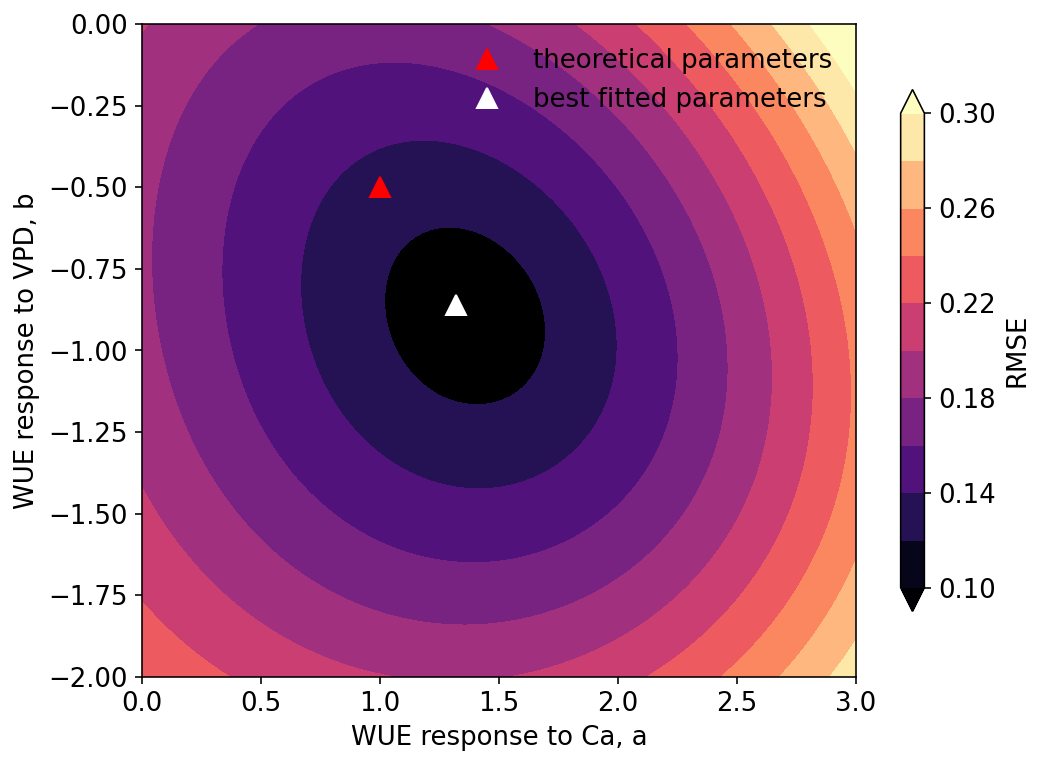

In [24]:
plt.rcParams['font.size'] = 13
fig ,ax = plt.subplots(figsize=(8,6))

cb = ax.contourf(a,b,RMSE,cmap='magma',levels=np.arange(0.1,0.32,0.02),extend='both')
cs = ax.contourf(a, b, RMSE, levels=[0,RMSE.min()*(1+0.05)],colors='black') # , linewidths=1.5,linestyles='--'
fig.colorbar(cb,shrink=0.8,label='RMSE')

ax.set_xlabel('WUE response to Ca, a')
ax.set_ylabel('WUE response to VPD, b')
ax.plot(1, -0.5, 'r^',markersize=10,label='theoretical parameters')
ax.plot(param[0],param[1],'w^',markersize=10,label='best fitted parameters')

ax.legend(frameon=False)
plt.rcParams['savefig.dpi'] = 220
T = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# plt.savefig('./Data/figs/Curve_fitting_'+T+'.png')

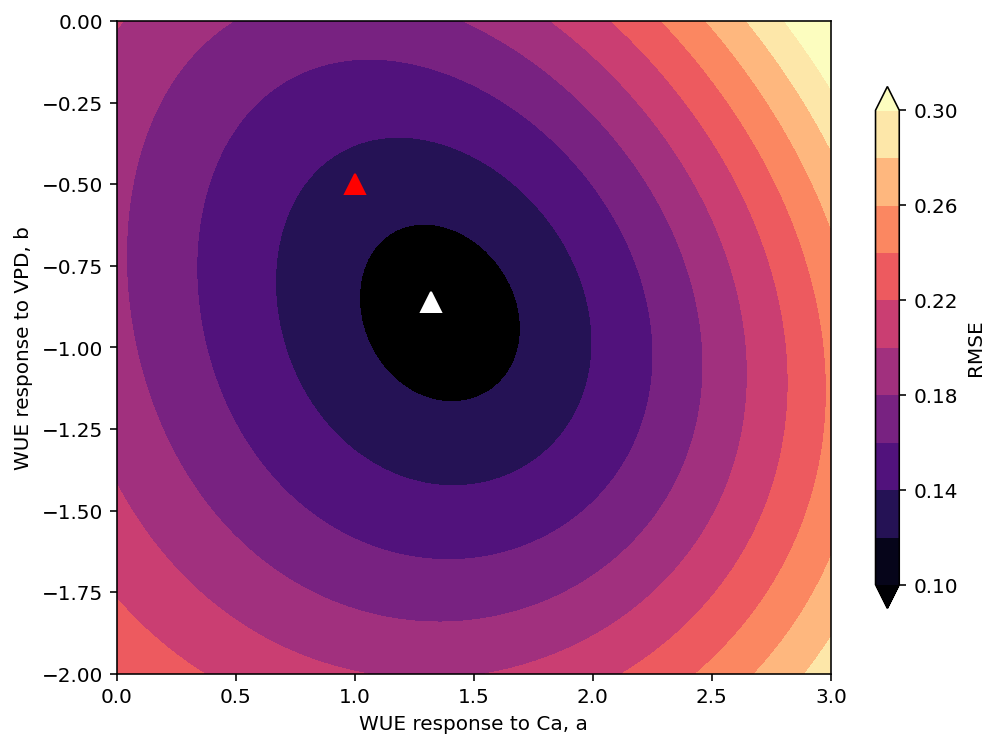

In [210]:
fig ,ax = plt.subplots(figsize=(8,6))

cb = ax.contourf(a,b,RMSE,cmap='magma',levels=np.arange(0.1,0.32,0.02),extend='both')
cs = ax.contourf(a, b, RMSE, levels=[0,RMSE.min()*(1+0.05)],colors='black') # , linewidths=1.5,linestyles='--'
fig.colorbar(cb,shrink=0.8,label='RMSE')

ax.set_xlabel('WUE response to Ca, a')
ax.set_ylabel('WUE response to VPD, b')
ax.plot(1, -0.5, 'r^',markersize=10)
ax.plot(param[0],param[1],'w^',markersize=10)